In [3]:
pip install numpy pandas pathlib matplotlib ipython tensorflow tqdm opencv-python-headless albumentations scikit-learn glob2



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm

import tensorflow as tf 

import os
import shutil
from tqdm import tqdm
from random import shuffle

import cv2
from glob import glob

from tensorflow.keras import backend as K
import random
import albumentations as A
from sklearn.model_selection import train_test_split, StratifiedKFold

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *


2025-02-21 19:23:45.366470: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-21 19:23:45.369192: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-21 19:23:45.377941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740146025.393621  275664 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740146025.398025  275664 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-21 19:23:45.412845: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [5]:
ls

 CustomSnakeClassification.ipynb   myVenv/  'Snake Images'/


In [6]:
image_dir = Path('./Snake Images')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [7]:
image_df.head(10)

,Filepath,Label
0,Snake Images/test/Non Venomous/Banded-Racer-3-...,Non Venomous
1,Snake Images/test/Non Venomous/7696c19d1eb4846...,Non Venomous
2,Snake Images/test/Non Venomous/27.jpg,Non Venomous
3,Snake Images/test/Non Venomous/78.jpg,Non Venomous
4,Snake Images/test/Non Venomous/5c3dd3dc91c4283...,Non Venomous
5,Snake Images/test/Non Venomous/26.jpg,Non Venomous
6,Snake Images/test/Non Venomous/Banded_Racer_Ar...,Non Venomous
7,Snake Images/test/Non Venomous/23acc8022303e37...,Non Venomous
8,Snake Images/test/Non Venomous/xenochrophis-pi...,Non Venomous
9,Snake Images/test/Non Venomous/112282-850x565-...,Non Venomous


In [9]:
image_df = image_df.sample(frac=1).reset_index(drop =True)

In [10]:
image_df.head(5)

,Filepath,Label
0,Snake Images/train/Non Venomous/indian-rock-py...,Non Venomous
1,Snake Images/train/Venomous/Echis_carinatus2.jpg,Venomous
2,Snake Images/train/Venomous/stock-photo-monocl...,Venomous
3,Snake Images/train/Non Venomous/87679859_XS.jpg,Non Venomous
4,Snake Images/test/Non Venomous/126763-004-312A...,Non Venomous


In [11]:
image_df.shape

(1944, 2)

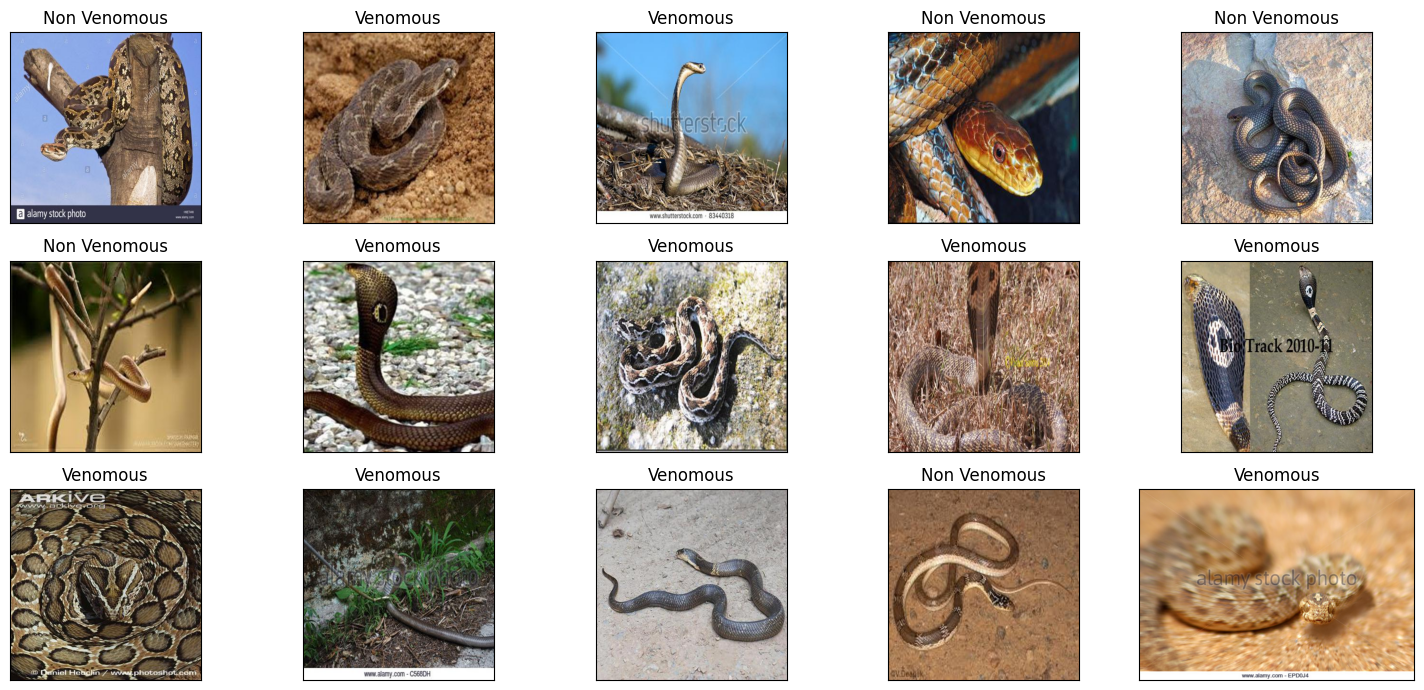

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [15]:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [16]:
train_df.shape

(1749, 2)

In [21]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [22]:
train_df.head(5)



,Filepath,Label
1836,Snake Images/train/Non Venomous/36 (2).jpg,Non Venomous
1821,Snake Images/train/Venomous/Deinagkistrodon-ac...,Venomous
1301,Snake Images/test/Non Venomous/26.jpg,Non Venomous
1753,Snake Images/test/Venomous/6O4A0417.jpg,Venomous
8,Snake Images/train/Venomous/Naja-naja-3-Specta...,Venomous


In [23]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1400 validated image filenames belonging to 2 classes.
Found 349 validated image filenames belonging to 2 classes.
Found 195 validated image filenames belonging to 2 classes.


In [25]:
def create_model(input_shape=(224, 224, 3)):
    
    inputs = Input(input_shape)
    base_model = EfficientNetB1(input_shape=input_shape, include_top=False, classes=2)
    
    x = base_model(inputs)
    
    x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.1)(x)
    
    x = Dense(56, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    outputs = Dense(2, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [27]:
K.clear_session()

model = create_model((224, 224, 3))

metrics = [
    'accuracy',
    'AUC'
]

In [28]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=metrics)


In [31]:
checkpoint_path = 'models/EfficientNetB1/model_224.h5'

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]


In [32]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25


/home/ariyaman/LearnToCode/Snake_Classification/myVenv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.7367 - accuracy: 0.6798 - loss: 0.5884  
Epoch 1: val_loss improved from inf to 0.77232, saving model to models/EfficientNetB1/model_224.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 229s 4s/step - AUC: 0.7380 - accuracy: 0.6807 - loss: 0.5872 - val_AUC: 0.4335 - val_accuracy: 0.4212 - val_loss: 0.7723 - learning_rate: 0.0010
Epoch 2/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.9715 - accuracy: 0.9294 - loss: 0.2166  
Epoch 2: val_loss improved from 0.77232 to 0.72343, saving model to models/EfficientNetB1/model_224.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - AUC: 0.9713 - accuracy: 0.9291 - loss: 0.2170 - val_AUC: 0.4288 - val_accuracy: 0.4269 - val_loss: 0.7234 - learning_rate: 0.0010
Epoch 3/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.9703 - accuracy: 0.9167 - loss: 0.2061  
Epoch 3: val_loss did not improve from 0.72343
44/44 ━━━━━━━━━━━━━━━━━━━━ 185s 4s/step - AUC: 0.9700 - accuracy: 0.9164 - loss: 0.2070 - val_AUC: 0.4043 - val_accuracy: 0.4269 - val_loss: 1.3987 - learning_rate: 0.0010
Epoch 4/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.9883 - accuracy: 0.9436 - loss: 0.1274  
Epoch 4: val_loss did not improve from 0.72343
44/44 ━━━━━━━━━━━━━━━━━━━━ 186s 4s/step - AUC: 0.9883 - accuracy: 0.9436 - loss: 0.1274 - val_AUC: 0.4294 - val_accuracy: 0.4441 - val_loss: 1.4165 - learning_rate: 0.0010
Epoch 5/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.9847 - accuracy: 0.9457 - loss: 0.1424  
Epoch 5: val_loss did not improve from 0.72343
44/44 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - AUC:

44/44 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - AUC: 1.0000 - accuracy: 0.9993 - loss: 0.0063 - val_AUC: 0.8225 - val_accuracy: 0.7278 - val_loss: 0.7064 - learning_rate: 1.0000e-05
Epoch 14/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - AUC: 1.0000 - accuracy: 0.9981 - loss: 0.0075  
Epoch 14: val_loss improved from 0.70644 to 0.61095, saving model to models/EfficientNetB1/model_224.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 210s 5s/step - AUC: 1.0000 - accuracy: 0.9981 - loss: 0.0076 - val_AUC: 0.8828 - val_accuracy: 0.8195 - val_loss: 0.6109 - learning_rate: 1.0000e-05
Epoch 15/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 1.0000 - accuracy: 1.0000 - loss: 0.0041  
Epoch 15: val_loss improved from 0.61095 to 0.57315, saving model to models/EfficientNetB1/model_224.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 198s 4s/step - AUC: 1.0000 - accuracy: 1.0000 - loss: 0.0041 - val_AUC: 0.9028 - val_accuracy: 0.8395 - val_loss: 0.5732 - learning_rate: 1.0000e-05
Epoch 16/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - AUC: 0.9998 - accuracy: 0.9960 - loss: 0.0118  
Epoch 16: val_loss improved from 0.57315 to 0.54527, saving model to models/EfficientNetB1/model_224.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 212s 5s/step - AUC: 0.9998 - accuracy: 0.9960 - loss: 0.0117 - val_AUC: 0.9147 - val_accuracy: 0.8567 - val_loss: 0.5453 - learning_rate: 1.0000e-05
Epoch 17/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - AUC: 1.0000 - accuracy: 0.9986 - loss: 0.0052  
Epoch 17: val_loss improved from 0.54527 to 0.52188, saving model to models/EfficientNetB1/model_224.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 210s 5s/step - AUC: 1.0000 - accuracy: 0.9986 - loss: 0.0052 - val_AUC: 0.9222 - val_accuracy: 0.8596 - val_loss: 0.5219 - learning_rate: 1.0000e-05
Epoch 18/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - AUC: 0.9999 - accuracy: 0.9982 - loss: 0.0059  
Epoch 18: val_loss improved from 0.52188 to 0.50817, saving model to models/EfficientNetB1/model_224.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 212s 5s/step - AUC: 0.9999 - accuracy: 0.9982 - loss: 0.0059 - val_AUC: 0.9267 - val_accuracy: 0.8567 - val_loss: 0.5082 - learning_rate: 1.0000e-05
Epoch 19/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.9998 - accuracy: 0.9954 - loss: 0.0128  
Epoch 19: val_loss improved from 0.50817 to 0.49770, saving model to models/EfficientNetB1/model_224.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 210s 5s/step - AUC: 0.9998 - accuracy: 0.9953 - loss: 0.0128 - val_AUC: 0.9301 - val_accuracy: 0.8682 - val_loss: 0.4977 - learning_rate: 1.0000e-05
Epoch 20/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 1.0000 - accuracy: 0.9997 - loss: 0.0047  
Epoch 20: val_loss improved from 0.49770 to 0.48802, saving model to models/EfficientNetB1/model_224.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 211s 5s/step - AUC: 1.0000 - accuracy: 0.9997 - loss: 0.0047 - val_AUC: 0.9328 - val_accuracy: 0.8682 - val_loss: 0.4880 - learning_rate: 1.0000e-05
Epoch 21/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 1.0000 - accuracy: 0.9985 - loss: 0.0072  
Epoch 21: val_loss improved from 0.48802 to 0.48521, saving model to models/EfficientNetB1/model_224.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 204s 5s/step - AUC: 1.0000 - accuracy: 0.9985 - loss: 0.0072 - val_AUC: 0.9338 - val_accuracy: 0.8682 - val_loss: 0.4852 - learning_rate: 1.0000e-05
Epoch 22/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - AUC: 1.0000 - accuracy: 0.9993 - loss: 0.0051  
Epoch 22: val_loss improved from 0.48521 to 0.48103, saving model to models/EfficientNetB1/model_224.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 224s 5s/step - AUC: 1.0000 - accuracy: 0.9993 - loss: 0.0051 - val_AUC: 0.9352 - val_accuracy: 0.8682 - val_loss: 0.4810 - learning_rate: 1.0000e-05
Epoch 23/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - AUC: 1.0000 - accuracy: 0.9967 - loss: 0.0060  
Epoch 23: val_loss improved from 0.48103 to 0.47611, saving model to models/EfficientNetB1/model_224.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 216s 5s/step - AUC: 1.0000 - accuracy: 0.9967 - loss: 0.0060 - val_AUC: 0.9362 - val_accuracy: 0.8711 - val_loss: 0.4761 - learning_rate: 1.0000e-05
Epoch 24/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - AUC: 0.9997 - accuracy: 0.9921 - loss: 0.0159  
Epoch 24: val_loss improved from 0.47611 to 0.47315, saving model to models/EfficientNetB1/model_224.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 213s 5s/step - AUC: 0.9997 - accuracy: 0.9922 - loss: 0.0157 - val_AUC: 0.9368 - val_accuracy: 0.8711 - val_loss: 0.4731 - learning_rate: 1.0000e-05
Epoch 25/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - AUC: 1.0000 - accuracy: 1.0000 - loss: 0.0043  
Epoch 25: val_loss improved from 0.47315 to 0.47138, saving model to models/EfficientNetB1/model_224.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 213s 5s/step - AUC: 1.0000 - accuracy: 1.0000 - loss: 0.0043 - val_AUC: 0.9372 - val_accuracy: 0.8711 - val_loss: 0.4714 - learning_rate: 1.0000e-05


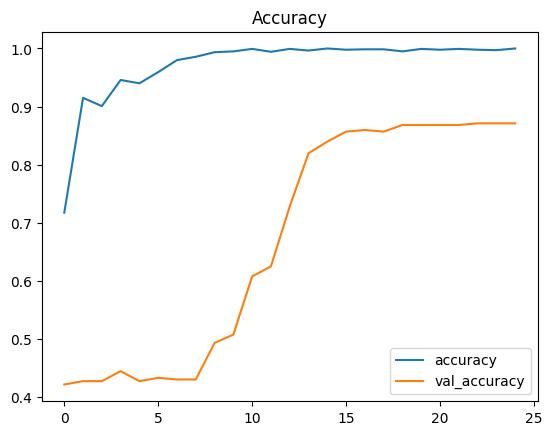

In [34]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()


In [36]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.23049
Test Accuracy: 92.82%


In [37]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step  
The first 5 predictions: ['Venomous', 'Venomous', 'Non Venomous', 'Non Venomous', 'Venomous']


In [38]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

Non Venomous       0.93      0.89      0.91        79
    Venomous       0.93      0.96      0.94       116

    accuracy                           0.93       195
   macro avg       0.93      0.92      0.92       195
weighted avg       0.93      0.93      0.93       195



In [41]:
pip install seaborn

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 1.0 MB/s eta 0:00:001.1 MB/s eta 0:00:01m

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


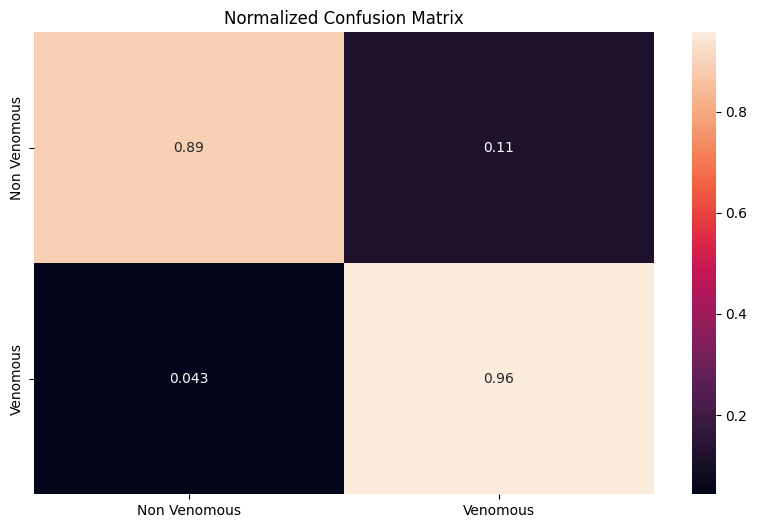

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

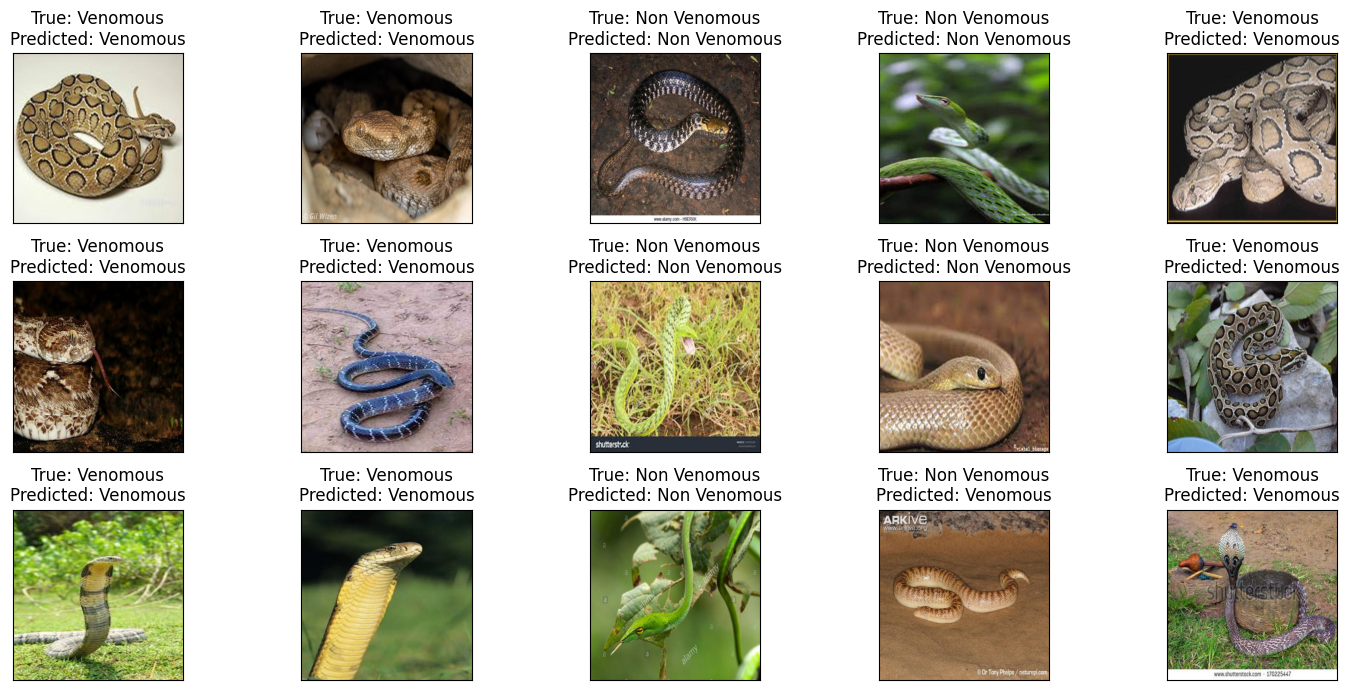

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [ ]:
model.save("/home/ariyaman/LearnToCode/Snake_Classification")